In [1]:
import pandas as pd
import maya
from collections import Counter
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('husl'))
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

# A simple look at Russian Troll Tweets
NBC recently published a dataset of over 200k russia-connected tweets deleted from twitter ([available here](https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731)). I thought it'd be interesting to take a look at them.

In [2]:
tweets = pd.read_csv('/data/ifox/russian_tweets_data/tweets.csv')
users = pd.read_csv('/data/ifox/russian_tweets_data/users.csv')

Let's start by taking a look at the data available:

In [3]:
print('tweets.csv:')
print('{:<25}{:<20}{:<25}'.format('Column Name', 'Non-Missing Count', '# Unique Values'))
print(''.join(['-' for _ in range(70)]))
for col in tweets.columns:
    print('{:<25}{:<20}{:<25}'.format(col, '{}/{}'.format(len(tweets[col].dropna()), len(tweets[col])), len(tweets[col].dropna().unique())))

tweets.csv:
Column Name              Non-Missing Count   # Unique Values          
----------------------------------------------------------------------
user_id                  195417/203482       393                      
user_key                 203482/203482       454                      
created_at               203461/203482       198421                   
created_str              203461/203482       198421                   
retweet_count            58083/203482        1229                     
retweeted                58083/203482        1                        
favorite_count           58083/203482        1167                     
text                     203461/203482       175214                   
tweet_id                 201168/203482       200661                   
source                   58084/203482        19                       
hashtags                 203482/203482       18343                    
expanded_urls            203482/203482       22215               

In [4]:
print('users.csv:')
print('{:<25}{:<20}{:<25}'.format('Column Name', 'Non-Missing Count', '# Unique Values'))
print(''.join(['-' for _ in range(70)]))
for col in users.columns:
    print('{:<25}{:<20}{:<25}'.format(col, '{}/{}'.format(len(users[col].dropna()), len(users[col])), len(users[col].dropna().unique())))

users.csv:
Column Name              Non-Missing Count   # Unique Values          
----------------------------------------------------------------------
id                       393/454             393                      
location                 285/454             107                      
name                     384/454             384                      
followers_count          384/454             348                      
statuses_count           384/454             367                      
time_zone                369/454             20                       
verified                 384/454             1                        
lang                     384/454             6                        
screen_name              454/454             454                      
description              339/454             339                      
created_at               384/454             384                      
favourites_count         384/454             328                  

So we have the text to 203k tweets from 393 users, who wrote under 454 screen names. Let's look at some of the user-level statistics:

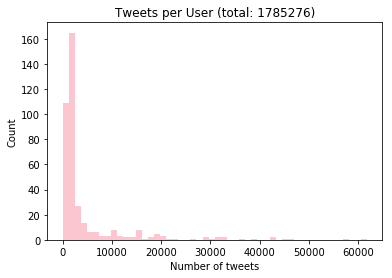

In [5]:
sns.distplot(users['statuses_count'].dropna(), kde=False)
plt.xlabel('Number of tweets')
plt.ylabel('Count')
plt.title('Tweets per User (total: {})'.format(int(users['statuses_count'].dropna().sum())))

Note these users have posted far more than the 203k deleted tweets. I don't know what happened to their other tweets.

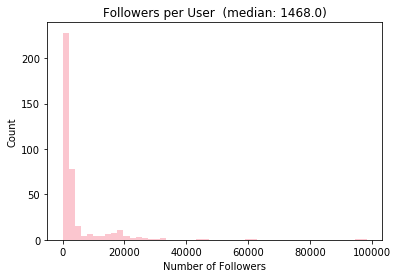

In [6]:
sns.distplot(users['followers_count'].dropna(), kde=False)
plt.xlabel('Number of Followers')
plt.ylabel('Count')
plt.title('Followers per User  (median: {})'.format(users['followers_count'].dropna().median()))

These accounts are pretty popular, the average twitter user had around 700 followers as of June 2016 ([source](https://kickfactory.com/blog/average-twitter-followers-updated-2016/)). Who are these bigshots?

In [7]:
users.query('followers_count > 5000').head(10)

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
4,4.496897e+08,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0
5,4.718689e+08,"Санкт-Петербург, Россия",Маргарита Саваж,23305.0,18401.0,Volgograd,False,ru,MargoSavazh,Честь имею. Нагло врать не умею.,Mon Jan 23 10:26:25 +0000 2012,1480.0,8021.0,231.0
73,1.687184e+09,USA,Bleep The Police,13196.0,13727.0,Eastern Time (US & Canada),False,en,BleepThePolice,"For a second at least, I'm resurrecting the pe...",Wed Aug 21 01:49:22 +0000 2013,11083.0,8071.0,163.0
105,2.484643e+09,NaN,Warfare Worldwide,23876.0,2618.0,St. Petersburg,False,en,WarfareWW,Political & Military Analyst,Mon Apr 14 17:32:56 +0000 2014,247.0,7481.0,565.0
109,2.495568e+09,"San Francisco, CA",San Francisco Daily,16812.0,32546.0,Pacific Time (US & Canada),False,en,DailySanFran,"Follow for San Francisco's breaking news, spec...",Thu May 15 03:22:22 +0000 2014,1.0,5128.0,159.0
143,2.547142e+09,"Chicago, IL",Chicago Daily News,19525.0,39293.0,Central Time (US & Canada),False,en,ChicagoDailyNew,"Local news, sports, business, politics, entert...",Wed May 14 10:48:50 +0000 2014,10.0,7063.0,214.0
150,2.570017e+09,"Memphis, TN",Memphis Online,18704.0,4223.0,Central Time (US & Canada),False,en,OnlineMemphis,"Breaking news, weather, traffic and more for M...",Thu May 29 01:01:16 +0000 2014,3.0,5751.0,113.0
152,2.570631e+09,United States,Politweecs,32846.0,559.0,Central Time (US & Canada),False,en,Politweecs,Tweets and politics,Thu May 29 16:09:26 +0000 2014,51.0,25600.0,117.0
154,2.571870e+09,"Detroit, Michigan",Detroit Daily News,18617.0,18924.0,Central Time (US & Canada),False,en,DetroitDailyNew,"Local news, sports, business, politics, entert...",Fri May 30 07:24:00 +0000 2014,4.0,5144.0,193.0
163,2.578422e+09,"Тула, Тульская область",Cоюзники России,21072.0,15364.0,Abu Dhabi,False,en,russianallies,Александр III: У России есть только два союзни...,Fri Jun 20 10:17:19 +0000 2014,0.0,2926.0,134.0


Hmm...interesting mix of newspaper-like entities and Russian names. Is there a correlation between number of tweets and followers?

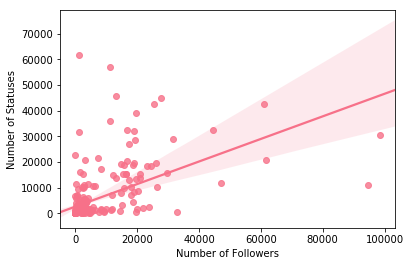

In [8]:
followers = users['followers_count']
statuses = users['statuses_count']
sns.regplot(followers, statuses)
plt.xlabel('Number of Followers')
plt.ylabel('Number of Statuses')

Seems like it, what about number of deleted statuses (since as shown previously, not all their tweets are in this dataset)?

In [9]:
followers = []
deleted_statuses = []
for uid in tqdm(users['id'].dropna()):
    followers.append(int(users.query('id == {}'.format(uid))['followers_count'].sum()))
    deleted_statuses.append(len(tweets.query('user_id == {}'.format(uid))))

HBox(children=(IntProgress(value=0, max=393), HTML(value='')))

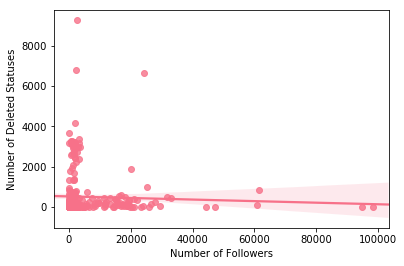

In [10]:
sns.regplot(np.array(followers), np.array(deleted_statuses))
plt.xlabel('Number of Followers')
plt.ylabel('Number of Deleted Statuses')

So it looks like only the more popular accounts didn't have many deleted tweets. What does the timeline of deleted tweets and users look like?

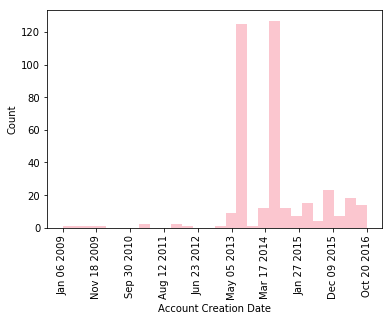

In [11]:
user_epochs = [maya.parse(t).epoch for t in users['created_at'].dropna().values]
sns.distplot(user_epochs, kde=False)
plt.xticks(np.linspace(min(user_epochs), max(user_epochs), 10), 
           [maya.MayaDT(epoch=e).slang_date() for e in np.linspace(min(user_epochs), max(user_epochs), 10)], rotation=90)
plt.xlabel('Account Creation Date')
plt.ylabel('Count')

We see these accounts were created over a pretty long stretch of time, with two pronounced peaks. What about the tweets?

In [12]:
tweet_epochs = [maya.parse(t).epoch for t in tqdm(tweets['created_str'].dropna().values)]

HBox(children=(IntProgress(value=0, max=203461), HTML(value='')))

In [13]:
clinton_announce = maya.parse('April 12, 2015')
trump_announce = maya.parse('June 16, 2015')
trump_candidate = maya.parse('July 21, 2016')
election_day = maya.parse('November 8, 2016')
inaguaration_day = maya.parse('January 20, 2017')

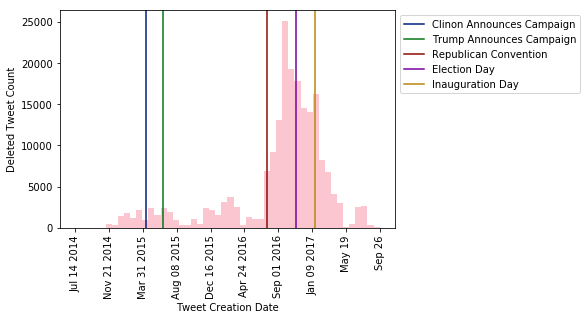

In [14]:
palette = sns.color_palette('dark')
sns.distplot(tweet_epochs, kde=False)
plt.xticks(np.linspace(min(tweet_epochs), max(tweet_epochs), 10), 
           [maya.MayaDT(epoch=e).slang_date() for e in np.linspace(min(tweet_epochs), max(tweet_epochs), 10)], rotation=90)
plt.axvline(clinton_announce.epoch, color=palette[0], label='Clinon Announces Campaign')
plt.axvline(trump_announce.epoch, color=palette[1], label='Trump Announces Campaign')
plt.axvline(trump_candidate.epoch, color=palette[2], label='Republican Convention')
plt.axvline(election_day.epoch, color=palette[3], label='Election Day')
plt.axvline(inaguaration_day.epoch, color=palette[4], label='Inauguration Day')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Deleted Tweet Count')
plt.legend(loc='best', bbox_to_anchor=(1,1))

It looks like many of the tweets occurred after the election. Since this is twitter, let's take a look at the hashtags used.

In [15]:
hashtags = []
for h in tweets['hashtags']:
    hashtags += ast.literal_eval(h)

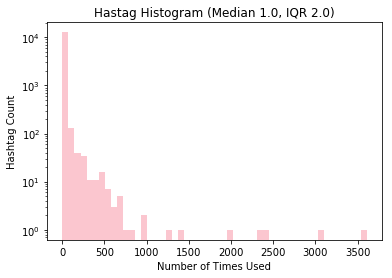

In [16]:
hashtag_counts = list(Counter(hashtags).values())
sns.distplot(hashtag_counts, kde=False)
plt.yscale('log')
plt.xlabel('Number of Times Used')
plt.ylabel('Hashtag Count')
hashtag_percentiles = np.percentile(hashtag_counts, [25, 50, 75])
plt.title('Hastag Histogram (Median {}, IQR {})'.format(hashtag_percentiles[1], hashtag_percentiles[2]-hashtag_percentiles[0]))

The majority of hashtags used were one-offs. What about the couple most popular?

In [17]:
most_popular = []
print('Tag: Count')
print('-----------')
for c in Counter(hashtags).most_common(20):
    print('{}: {}'.format(c[0], c[1]))
    most_popular.append(c[0])

Tag: Count
-----------
Politics: 3606
maga: 3079
Trump: 2425
tcot: 2366
news: 1973
NeverHillary: 1375
pjnet: 1276
TrumpPence16: 980
Trump2016: 947
MerkelMussBleiben: 796
Hillary: 758
TrumpTrain: 719
HillaryClinton: 704
CrookedHillary: 678
WakeUpAmerica: 661
RejectedDebateTopics: 657
CCOT: 600
Obama: 599
Blacklivesmatter: 581
2A: 565


In [18]:
hashtag_ts = {tag:[] for tag in most_popular}
for i in tqdm(range(len(tweets))):
    if pd.isnull(tweets['created_str'][i]):
        continue
    tweet_tags = ast.literal_eval(tweets['hashtags'][i])
    for tag in tweet_tags:
        if tag in most_popular:
            hashtag_ts[tag].append(maya.parse(tweets['created_str'][i]).epoch)

HBox(children=(IntProgress(value=0, max=203482), HTML(value='')))

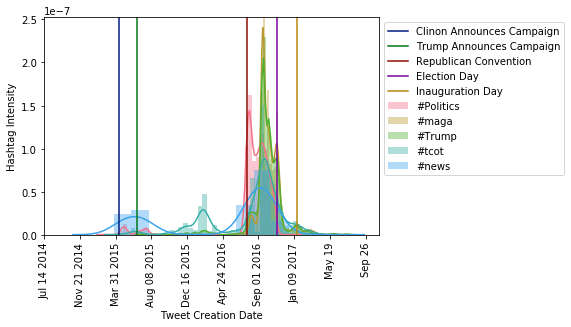

In [20]:
for tag in most_popular[0:5]:
    sns.distplot(hashtag_ts[tag], label='#{}'.format(tag))
plt.xticks(np.linspace(min(tweet_epochs), max(tweet_epochs), 10), 
           [maya.MayaDT(epoch=e).slang_date() for e in np.linspace(min(tweet_epochs), max(tweet_epochs), 10)], rotation=90)
plt.axvline(clinton_announce.epoch, color=palette[0], label='Clinon Announces Campaign')
plt.axvline(trump_announce.epoch, color=palette[1], label='Trump Announces Campaign')
plt.axvline(trump_candidate.epoch, color=palette[2], label='Republican Convention')
plt.axvline(election_day.epoch, color=palette[3], label='Election Day')
plt.axvline(inaguaration_day.epoch, color=palette[4], label='Inauguration Day')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Hashtag Intensity')
plt.legend(loc='best', bbox_to_anchor=(1,1))

Looks like most hashtags were used between republican convention and election day. The hashtag-to-tweet ratio seems pretty inconstant. In case you wanted to see all the most popular hashtags over time, here they are:

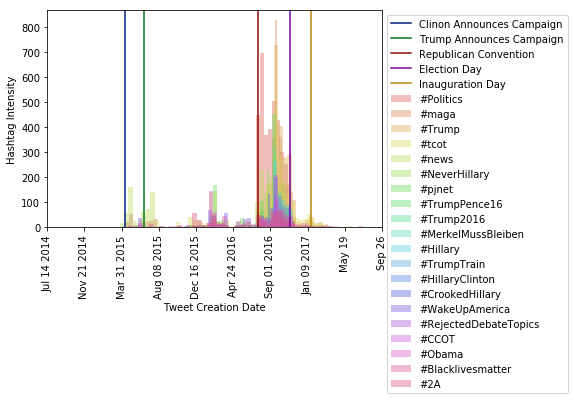

In [32]:
palette2 = sns.color_palette('hls', 20)
i = 0
for tag in most_popular:
    sns.distplot(hashtag_ts[tag], kde=False, bins=50, label='#{}'.format(tag), color=palette2[i])
    i += 1
plt.xticks(np.linspace(min(tweet_epochs), max(tweet_epochs), 10), 
           [maya.MayaDT(epoch=e).slang_date() for e in np.linspace(min(tweet_epochs), max(tweet_epochs), 10)], rotation=90)
plt.axvline(clinton_announce.epoch, color=palette[0], label='Clinon Announces Campaign')
plt.axvline(trump_announce.epoch, color=palette[1], label='Trump Announces Campaign')
plt.axvline(trump_candidate.epoch, color=palette[2], label='Republican Convention')
plt.axvline(election_day.epoch, color=palette[3], label='Election Day')
plt.axvline(inaguaration_day.epoch, color=palette[4], label='Inauguration Day')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Hashtag Intensity')
plt.legend(loc='best', bbox_to_anchor=(1,1))

# TODO: some NLP with spacy